## Utilities

In [1]:
%run ../common_functions.py

read_dataset()
read_all_datasets()
read_processed_data()
combine_text_columns()
split_train_test()
extract_data()
evaluate_model()
detect_missing_values()


## Imports

In [2]:
import yaml
import pandas as pd
from tqdm.auto import tqdm
from random import choice

In [3]:
from data_preprocessing.text_cleaning import (
    remove_html,
    remove_urls,
    remove_digits,
    remove_punctuation,
    remove_special_characters,
    normalize_whitespace,
    to_lowercase
)
from data_preprocessing.add_domain import add_domain
from data_preprocessing.find_and_remove_duplicates import find_and_remove_dups

In [4]:
from data_augmentation.synonym_replacement import replace_synonyms_database, replace_synonyms_llm
from data_augmentation.paraphrasing import paraphrase_llm
from data_augmentation.style_transfer import transfer_style_llm

In [4]:
from constants import DATASETS

## Load config

In [5]:
with open("config.yml", "r") as f:
    config = yaml.safe_load(f)

## Load Data

In [4]:
data = read_all_datasets()

# -- Orchestration --

## Data Preprocessing

### Find and Remove duplicate Data

In [8]:
datasets = {dataset: read_dataset(dataset) for dataset in DATASETS}
data = find_and_remove_dups(data, datasets)

Total rows                 : 354608
Unique 'text' entries      : 319222
Duplicate 'text' entries   : 35386 (9.98% of total)


==DUPLICATES WITHIN DATASET==
  • Climate-FEVER: 0 duplicates removed, rows 1535→1535 (-0.00%)
  • Fake News Corpus: 7335 duplicates removed, rows 70846→63511 (-10.35%)
  • Fakeddit: 40 duplicates removed, rows 7000→6960 (-0.57%)
  • FakeNewsNet: 1472 duplicates removed, rows 23196→21724 (-6.35%)
  • FEVER: 7518 duplicates removed, rows 109810→102292 (-6.85%)
  • FineFake: 1408 duplicates removed, rows 16909→15501 (-8.33%)
  • LIAR2: 34 duplicates removed, rows 22962→22928 (-0.15%)
  • llm-misinformation: 3034 duplicates removed, rows 7057→4023 (-42.99%)
  • MultiFC: 28 duplicates removed, rows 21148→21120 (-0.13%)
  • Source based FN: 40 duplicates removed, rows 2050→2010 (-1.95%)
  • WELFake: 8456 duplicates removed, rows 72095→63639 (-11.73%)
=> Found 29365 duplicated rows in total


==DUPLICATES ACROSS DATASETS==
  • Climate-FEVER & LIAR2: 25 overlaps (1.63%

### Domain Tagging

Computing sentence embeddings...


Batches:   0%|          | 0/59 [00:00<?, ?it/s]

Initializing KMeans with k=13 Clusters...
Predicting domains with KMeans...
Mapping domain IDs to topic names...
Plotting...
5000


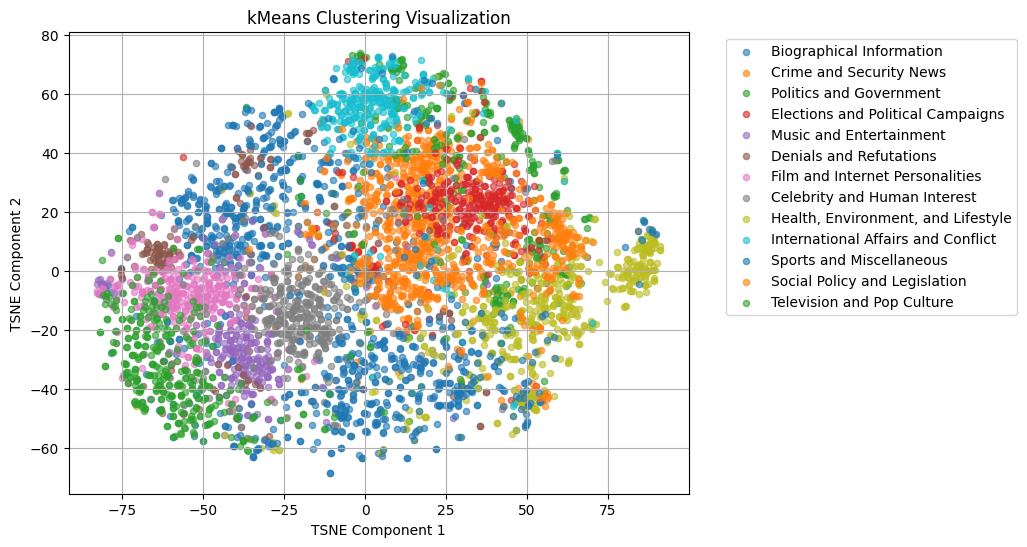



Topic Distribution: domain
Sports and Miscellaneous              1842
Health, Environment, and Lifestyle    1622
Crime and Security News               1614
Social Policy and Legislation         1174
Elections and Political Campaigns     1155
Celebrity and Human Interest          1149
Biographical Information              1118
Politics and Government               1072
Television and Pop Culture            1062
Film and Internet Personalities       1024
International Affairs and Conflict     948
Music and Entertainment                709
Denials and Refutations                511
Name: count, dtype: int64


,text,label,domain
330109,Big Banks Fleeced The Working Poor Out Of $11...,1,"Health, Environment, and Lifestyle"
104327,Trumbo starred Bryan Cranston.,0,Film and Internet Personalities
183322,To Kill a Mockingbird completely avoids the th...,1,Denials and Refutations
213577,PsBattle: Cat in a car,0,Sports and Miscellaneous
109518,Minos fathered a child.,0,Biographical Information
...,...,...,...
292234,JetBlue offers $99 flights out of Florida ahea...,0,"Health, Environment, and Lifestyle"
328787,BREAKING: Uncovered Huma Email Confirms the Wo...,1,Crime and Security News
274214,"The proposed state budget contains ""an additio...",1,Social Policy and Legislation
97724,Jen Aniston Furious Over ‘Friends’ Off-Broadwa...,1,Celebrity and Human Interest


In [5]:
data = data.sample(n=15_000)
add_domain(data, k=13, plot_kmeans=True)

In [9]:
data = add_domain(data, 
                  k=config["domain_tagging"]["n_domains"],
                  save_embeddings=config["domain_tagging"]["save_embeddings"], 
                  use_saved_embeddings=config["domain_tagging"]["use_saved_embeddings"],
                  plot_kmeans=config["domain_tagging"]["plot"])

Reading saved sentence embeddings...
Initializing KMeans with k=13 Clusters...
Predicting domains with KMeans...
Mapping domain IDs to topic names...


KeyboardInterrupt: 

## Data Augmentation

### Synonym Replacement

In [10]:
if config["augmentation"]["synonym_replacement"]["enabled"]:
    n_samples = int(max(config["augmentation"]["synonym_replacement"]["n_samples"] * len(data), 1))
    n_replacements = 2

    sampled = data.sample(n=n_samples, random_state=42).copy()
    augmented_texts = []

    if config["augmentation_methods"]["local_database"]:
        for text in tqdm(sampled['text'], total=n_samples):
            augmented_texts.append(replace_synonyms_database(text, n_replacements))
    elif config["augmentation_methods"]["llm"]:
        for text in tqdm(sampled['text'], total=n_samples):
            augmented_texts.append(replace_synonyms_llm(text, n_replacements))
    
    if len(augmented_texts):
        sampled['text'] = augmented_texts

        data = pd.concat([data, sampled], ignore_index=True)

### Paraphrasing

In [11]:
if config["augmentation"]["paraphrasing"]["enabled"]:
    n_samples = int(max(config["augmentation"]["paraphrasing"]["n_samples"] * len(data), 1))

    sampled = data.sample(n=n_samples, random_state=42).copy()
    augmented_texts = []

    if config["augmentation_methods"]["llm"]:
        for text in tqdm(sampled['text'], total=n_samples):
            augmented_texts.append(paraphrase_llm(text))
    
        sampled['text'] = augmented_texts

        data = pd.concat([data, sampled], ignore_index=True)

### Style Transfer

In [12]:
if config["augmentation"]["style_transfer"]["enabled"]:
    n_samples = int(max(config["augmentation"]["paraphrasing"]["n_samples"] * len(data), 1))
    target_styles = [
        "Neutral journalistic",
        "Slightly formal",
        "Slightly informal",
        "Objective report",
        "Simplified for general audience",
        "Summarized headline-style",
        "Explanatory tone",
        "Skeptical tone",
        "Curious/inquisitive tone"]

    sampled = data.sample(n=n_samples, random_state=42).copy()
    augmented_texts = []

    if config["augmentation_methods"]["llm"]:
        for text in tqdm(sampled['text'], total=n_samples):
            augmented_texts.append(transfer_style_llm(text, choice(target_styles)))
    
        sampled['text'] = augmented_texts

        data = pd.concat([data, sampled], ignore_index=True)

## Data Preprocessing

### Text Cleaning

In [13]:
def clean_text(text, config):
    if config.get("strip_html"):
        text = remove_html(text)
    if config.get("remove_urls"):
        text = remove_urls(text)
    if config.get("remove_digits"):
        text = remove_digits(text)
    if config.get("remove_punctuation"):
        text = remove_punctuation(text)
    if config.get("remove_special_chars"):
        text = remove_special_characters(text)
    if config.get("lowercase"):
        text = to_lowercase(text)
    if config.get("normalize_whitespace"):
        text = normalize_whitespace(text)
    
    return text

In [14]:
data["text"] = data["text"].apply(lambda x: clean_text(x, config["preprocessing"]))

## Save Output

In [15]:
augmented = any([config["augmentation"]["synonym_replacement"]["enabled"],
                config["augmentation"]["paraphrasing"]["enabled"],
                config["augmentation"]["style_transfer"]["enabled"]])

data.to_parquet(f"{config['output']}/preprocessed_data{'_augmented' if augmented else ''}.parquet", index=False)